In [ ]:
import random
import functools
import numpy as np
from deap import base, creator, tools, algorithms
import gurobipy as gp
import pandapower as pp
from pandapower.powerflow import LoadflowNotConverged
import matplotlib.pyplot as plt

# ---------- Gurobi 환경 (로그 출력 OFF) ----------
GRB_ENV = gp.Env()
GRB_ENV.start()
GRB_ENV.setParam('OutputFlag', 0)

# -------- 전역 변수 정의 --------
T = range(24)
T_plus1 = range(len(T) + 1)

# 버스 데이터: (ID, type, P_MW, Q_MVAR, Vset, theta)
bus_data = np.array([
    [1, 1,  0.0, 0.0, 1.05, 0.0],
    [2, 2,  0.0, 0.0, 1.05, None],
    [3, 2,  0.0, 0.0, 1.05, None],
    [4, 3,  7.8, 3.9,  None, None],
    [5, 3,  7.6, 0.6,  None, None],
    [6, 2,  0.0, 0.0, 1.05, None],
    [7, 3,  1.0, 0.0,  None, None],
    [8, 2,  0.0, 0.0, 1.05, None],
    [9, 3, 29.5, 3.6,  None, None],
    [10,3,  9.0, 1.5,  None, None],
    [11,3,  3.5, 0.1,  None, None],
    [12,3,  6.1, 0.6,  None, None],
    [13,3,  3.7, 2.8,  None, None],
    [14,3,  2.0, 1.0,  None, None],
], dtype=float)

# 선로 데이터: (from, to, r, x, b)
branch_data = np.array([
 [1,2,0.01938,0.05917,0.0528], [1,5,0.05403,0.22304,0.0492],
 [2,3,0.04699,0.19797,0.0438], [2,4,0.05811,0.17632,0.0340],
 [2,5,0.05695,0.17388,0.0346], [3,4,0.06701,0.17103,0.0128],
 [4,5,0.01335,0.04211,0.0 ], [4,7,0.0,    0.20912,0.0 ],
 [4,9,0.0,    0.55618,0.0 ], [5,6,0.0,    0.25202,0.0 ],
 [6,11,0.09498,0.19890,0.0], [6,12,0.12291,0.25581,0.0],
 [6,13,0.06615,0.13027,0.0], [7,8,0.0,    0.17615,0.0 ],
 [7,9,0.0,    0.11001,0.0 ], [9,10,0.03181,0.08450,0.0],
 [9,14,0.12711,0.27038,0.0], [10,11,0.08205,0.19207,0.0],
 [12,13,0.22092,0.19988,0.0], [13,14,0.17093,0.34802,0.0],
], dtype=float)

# 수요 및 태양광 프로파일
demand_profile = [1200.0] * 24
solar_shape    = [0]*5 + [20,50,100,150,180,200,180,150,100,50,20] + [0]*8

# 연료비용
fuel_cost = [
 [120.67,113.74,84.96,84.96,84.96,84.96,94.7,98.42,116.93,137.92,145.44,148.05,148.05,138.96,148.65,166.11,166.11,141.09,141.09,141.10,137.54,137.91,137.93,137.42],
 [116.4]*8 + [169.3]*3 + [251.4] + [169.3,251.4,251.4,251.4,251.4,251.4,169.3,169.3,169.3,169.3] + [116.4]*2,
 [116.4]*8 + [169.3]*3 + [251.4] + [169.3,251.4,251.4,251.4,251.4,251.4,169.3,169.3,169.3,169.3] + [116.4]*2,
]

# CO2 배출 계수 및 비용 계수
CO2_w           = [0.8, 0.5, 0.8]
alpha_co2_cost  = 10
capex_pv_per_mw = 300
capex_ess_per_mwh = 20

# ESS 설치 후보 버스 및 발전 범위
ESS_BUSES = [4,5,7,9,10,11,12,13,14]
P_min, P_max = [0,0,0], [1000,150,500]

# 모선별 초기 carbon intensity
CARBON_INTENSITIES = {1:0.9, 2:CO2_w[0], 3:CO2_w[1], 6:0.0, 8:CO2_w[2]}
NUM_BUSES = len(bus_data)

# =========================================================
# 경제급전 함수
def economic_dispatch(pv_size, ess_cap, penalty=1e8):
    try:
        m = gp.Model(env=GRB_ENV)
        m.Params.OutputFlag = 0
        n = 3
        lbP = {(g,t): P_min[g] for g in range(n) for t in T}
        ubP = {(g,t): P_max[g] for g in range(n) for t in T}

        P   = m.addVars(n,T, lb=lbP, ub=ubP, name="P")
        SOE = m.addVars(T_plus1, lb=0, ub=ess_cap, name="SOE")
        ch  = m.addVars(T, lb=0, name="ch")
        dch = m.addVars(T, lb=0, name="dch")
        sw  = m.addVars(T, vtype=gp.GRB.BINARY, name="mode")

        cost = (
            gp.quicksum(fuel_cost[g][t]*P[g,t] for g in range(n) for t in T)
            + alpha_co2_cost*gp.quicksum(CO2_w[g]*P[g,t] for g in range(n) for t in T)
            + capex_pv_per_mw*pv_size + capex_ess_per_mwh*ess_cap
        )
        m.setObjective(cost, gp.GRB.MINIMIZE)
        m.addConstr(SOE[0]==0)
        for t in T:
            pv_gen = pv_size*solar_shape[t]/1000
            m.addConstr(gp.quicksum(P[g,t] for g in range(n)) + dch[t] == demand_profile[t] - pv_gen + ch[t])
            m.addConstr(ch[t]  <= sw[t]*ess_cap/4)
            m.addConstr(dch[t] <= (1-sw[t])*ess_cap/4)
            m.addConstr(SOE[t+1]==SOE[t] + 0.97*ch[t] - dch[t]/0.97)
        m.optimize()
        if m.Status != gp.GRB.OPTIMAL:
            return penalty, None, None, None
        P_disp = np.array([[P[g,t].X for t in T] for g in range(n)])
        ch_val  = [ch[t].X for t in T]
        dch_val = [dch[t].X for t in T]
        return m.ObjVal, P_disp, ch_val, dch_val
    except gp.GurobiError:
        return penalty, None, None, None

# pandapower 네트워크 빌더
def build_network():
    net = pp.create_empty_network(sn_mva=100)
    for bid, *_ in bus_data:
        pp.create_bus(net, name=f"Bus {int(bid)}", vn_kv=22.9)
    pp.create_ext_grid(net, bus=0, vm_pu=1.05)
    therm_map = {2:0,3:1,8:2}
    for bid, idx in therm_map.items():
        pp.create_gen(net,bus=bid-1,p_mw=0,vm_pu=1.05,name=f"G{idx+1}")
    pp.create_sgen(net,bus=5,p_mw=0,name="PV")
    for bid, typ,P_val,Q_val,*_ in bus_data:
        if int(typ)==3:
            pp.create_load(net,bus=int(bid)-1,p_mw=P_val,q_mvar=Q_val)
    for f,t,r,x,b in branch_data:
        pp.create_line_from_parameters(net,int(f-1),int(t-1),1,r*100,x*100,b*1e9,max_i_ka=1)
    return net, therm_map
BASE_NET, THERM_MAP = build_network()

# 내부 GA 정의
for cname in ("FitSlack","IndSlack"):  
    if cname in creator.__dict__: delattr(creator,cname)
creator.create("FitSlack", base.Fitness, weights=(-1.0,))
creator.create("IndSlack", list, fitness=creator.FitSlack)

tb_in = base.Toolbox()
tb_in.register("gene", random.randint,0,100)
tb_in.register("individual",tools.initRepeat,creator.IndSlack,tb_in.gene,n=len(ESS_BUSES))
tb_in.register("population",tools.initRepeat,list,tb_in.individual)
tb_in.register("mate",tools.cxTwoPoint)
tb_in.register("mutate",tools.mutUniformInt,low=0,up=100,indpb=0.2)
tb_in.register("select",tools.selTournament,tournsize=3)
VOLT_PEN_FACTOR=1e4

def eval_ess(ind,*,ess_cap,ch,dch,P_dispatch,pv_size):
    w=np.asarray(ind,float)
    if w.sum()==0: return(1e6,)
    frac=w/w.sum(); cap_bus=frac*ess_cap
    net=BASE_NET.deepcopy(); slack_sum=0; volt_pen=0
    for t in T:
        for bid,gidx in THERM_MAP.items(): net.gen.loc[net.gen.bus==bid-1,'p_mw']=P_dispatch[gidx][t]
        net.sgen.loc[net.sgen.name=="PV",'p_mw']=pv_size*solar_shape[t]/1000
        for idx,bid in enumerate(ESS_BUSES):
            idxs=net.load[net.load.bus==bid-1].index
            if idxs.empty: idxs=[pp.create_load(net,bus=bid-1,p_mw=0,q_mvar=0)]
            adj=cap_bus[idx]/ess_cap*(ch[t]-dch[t]); net.load.at[idxs[0],'p_mw']+=adj
        try:
            pp.runpp(net,init="auto",calculate_voltage_angles=True,tolerance_mva=1e-5,max_iteration=20)
            slack_sum+=net.res_ext_grid.p_mw.sum()
            vm=net.res_bus.vm_pu.values; dev=np.clip(0.95-vm,0,None)+np.clip(vm-1.05,0,None)
            volt_pen+=dev.sum()
        except LoadflowNotConverged:
            return(1e6,)
    return (slack_sum+VOLT_PEN_FACTOR*volt_pen,)

# 외부 GA 정의
for cname in ("FitOuter","IndOuter"):  
    if cname in creator.__dict__: delattr(creator,cname)
creator.create("FitOuter",base.Fitness,weights=(-1.0,))
creator.create("IndOuter",list,fitness=creator.FitOuter)

tb_out=base.Toolbox()
tb_out.register("pv",random.randint,0,200)
tb_out.register("ess",random.randint,0,200)
tb_out.register("individual",tools.initCycle,creator.IndOuter,(tb_out.pv,tb_out.ess),n=1)
tb_out.register("population",tools.initRepeat,list,tb_out.individual)
tb_out.register("mate",tools.cxTwoPoint)
tb_out.register("mutate",tools.mutUniformInt,low=[0,0],up=[200,200],indpb=0.2)
tb_out.register("select",tools.selTournament,tournsize=3)

def fitness_outer(ind):
    pv,ess=ind; cost,P_disp,ch,dch=economic_dispatch(pv,ess)
    if P_disp is None: return(1e9,)
    tb_in.register("evaluate",functools.partial(eval_ess,ess_cap=ess,ch=ch,dch=dch,P_dispatch=P_disp,pv_size=pv))
    pop_in=tb_in.population(30); hof_in=tools.HallOfFame(1)
    algorithms.eaSimple(pop_in,tb_in,cxpb=0.5,mutpb=0.3,ngen=30,halloffame=hof_in,verbose=False)
    return (cost+hof_in[0].fitness.values[0]*300,)
tb_out.register("evaluate",fitness_outer)

# CI 전파 함수 CEF해서 모선의 탄소강도 보여주는 코드
def calculate_bus_ci_propagation(net,carbon_intensities_dict,bus_data_ref):
    bus_no_to_pp={int(r[0]):i for i,r in enumerate(bus_data_ref)}
    pp_to_bus={v:k for k,v in bus_no_to_pp.items()}
    bus_ci={int(r[0]):np.nan for r in bus_data_ref}; gens=set()
    for r in bus_data_ref:
        bno,btype=int(r[0]),int(r[1])
        if btype in(1,2): bus_ci[bno]=carbon_intensities_dict.get(bno,np.nan); gens.add(bno)
    for _ in range(20):
        prev=bus_ci.copy(); upd=False
        for tgt in bus_ci:
            if tgt in gens: continue
            tp=bus_no_to_pp.get(tgt); totp=0; totc=0
            for li,line in net.line.iterrows():
                if li not in net.res_line.index: continue
                if line.to_bus==tp and net.res_line.p_from_mw[li]>1e-6:
                    src=pp_to_bus[line.from_bus]; ci=prev.get(src,np.nan)
                    if not np.isnan(ci): p=abs(net.res_line.p_to_mw[li]); totp+=p; totc+=p*ci
                if line.from_bus==tp and net.res_line.p_from_mw[li]<-1e-6:
                    src=pp_to_bus[line.to_bus]; ci=prev.get(src,np.nan)
                    if not np.isnan(ci): p=abs(net.res_line.p_from_mw[li]); totp+=p; totc+=p*ci
            if totp>1e-6:
                newci=totc/totp
                if np.isnan(bus_ci[tgt]) or abs(newci-bus_ci[tgt])>1e-4:
                    bus_ci[tgt]=newci; upd=True
        if not upd: break
    return bus_ci

if __name__=="__main__":
    pop=tb_out.population(40); hof=tools.HallOfFame(1)
    ms=tools.MultiStatistics(
        obj=tools.Statistics(lambda ind:ind.fitness.values[0]),
        pv=tools.Statistics(lambda ind:ind[0]),
        ess=tools.Statistics(lambda ind:ind[1])
    )
    ms.register("avg",np.mean); ms.register("min",np.min)
    pop,log=algorithms.eaSimple(pop,tb_out,cxpb=0.6,mutpb=0.3,ngen=40,halloffame=hof,stats=ms,verbose=True)
    best=hof[0]; pv,ess=best
    print(f"Best PV:{pv}MW, ESS:{ess}MWh, Obj:{best.fitness.values[0]:,.0f}")
    cost,P_disp,ch,dch=economic_dispatch(pv,ess)
    tb_in.register("evaluate",functools.partial(eval_ess,ess_cap=ess,ch=ch,dch=dch,P_dispatch=P_disp,pv_size=pv))
    pop_in=tb_in.population(50); hof_in=tools.HallOfFame(1)
    algorithms.eaSimple(pop_in,tb_in,cxpb=0.5,mutpb=0.3,ngen=30,halloffame=hof_in,verbose=False)
    w=np.asarray(hof_in[0],float); frac=w/w.sum(); dist=frac*ess
    print("\nBus별 ESS 분배(MWh):")
    for i, b in enumerate(ESS_BUSES):
        print(f"Bus {b:2d}: {dist[i]:.2f}")
    plt.figure(figsize=(10,4));plt.plot(list(T),ch,marker='o',label='Charge');plt.plot(list(T),dch,marker='s',label='Discharge');plt.xlabel('Hour');plt.ylabel('MW');plt.title('ESS Profile');plt.legend();plt.grid(True);plt.tight_layout();plt.show()
    final_net,_=build_network()
    for t in T:
        for bid,gidx in THERM_MAP.items(): final_net.gen.loc[final_net.gen.bus==bid-1,'p_mw']=P_disp[gidx][t]
        final_net.sgen.loc[final_net.sgen.name=='PV','p_mw']=pv*solar_shape[t]/1000
        for idx,bus in enumerate(ESS_BUSES): idxs=final_net.load[final_net.load.bus==bus-1].index; adj=dist[idx]/ess*(ch[t]-dch[t]); final_net.load.at[(idxs[0] if not idxs.empty else pp.create_load(final_net,bus=bus-1,p_mw=0,q_mvar=0)),'p_mw']+=adj
        try: pp.runpp(final_net,init='auto',calculate_voltage_angles=True,tolerance_mva=1e-5,max_iteration=20)
        except LoadflowNotConverged: pass
    ci_map=calculate_bus_ci_propagation(final_net,CARBON_INTENSITIES,bus_data); buses=sorted(ci_map.keys()); cis=[ci_map[b] for b in buses]
    plt.figure(figsize=(10,4));plt.plot(buses,cis,marker='o');[plt.text(x,y+0.01,f"{y:.3f}",ha='center') for x,y in zip(buses,cis)];plt.xlabel('Bus');plt.ylabel('CI');plt.title('Bus CO2 Intensity');plt.grid(axis='y',linestyle='--');plt.tight_layout();plt.show()


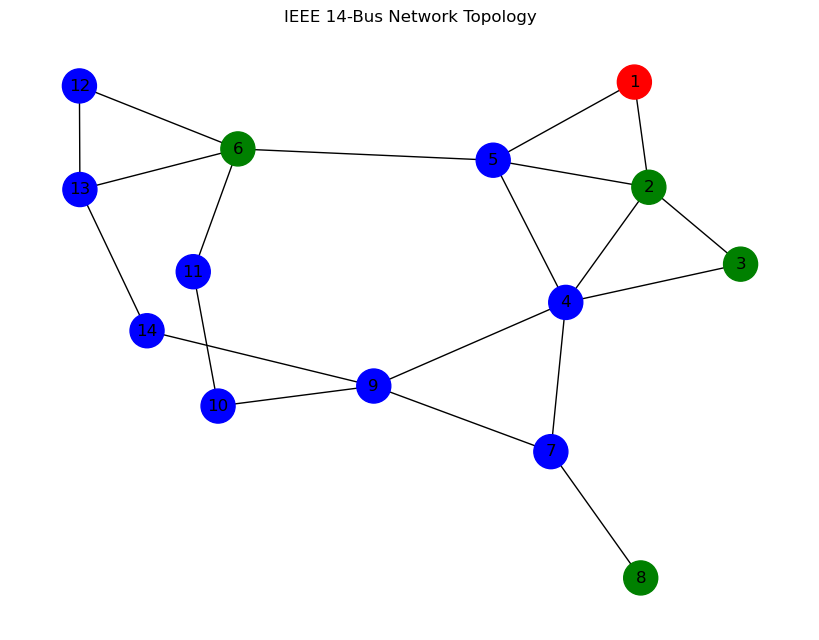

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# 각 발전원 마다 탄소강도를 매길 필요가 있다

weight_co2_gen=[1,0.9,0.8,0.7,0.6]

# === 시스템 데이터 ===
bus_data = np.array([
    [1,  1,    0.0,       0.0,       1.05, 0.0],    # Slack bus
    [2,  2,   21.7/100,   0.0,       1.05,  None],   # PV bus (Gen)
    [3,  2,   94.2/100,   0.0,       1.05,  None],   # PV bus (Gen)
    [4,  3,    7.8/100,   3.9/100,   None,   None],   # PQ bus (Load)
    [5,  3,    7.6/100,   0.6/100,   None,   None],
    [6,  2,   11.2/100,   0.0,       1.05,  None],   # PV bus (Gen)
    [7,  3,    1.0/100,   0.0,       None,   None],
    [8,  2,    5.0/100,   0.0,       1.05,  None],   # PV bus (Gen)
    [9,  3,   29.5/100,   3.6/100,   None,   None],
    [10, 3,    9/100,     1.5/100,   None,   None],
    [11, 3,    3.5/100,   0.1/100,   None,   None],
    [12, 3,    6.1/100,   0.6/100,   None,   None],
    [13, 3,    3.7/100,   2.8/100,   None,   None],
    [14, 3,    2.0/100,   1.0/100,   None,   None],
], dtype=object)

branch_data = np.array([
    [1, 2, 0.01938, 0.05917, 0.0528],
    [1, 5, 0.05403, 0.22304, 0.0492],
    [2, 3, 0.04699, 0.19797, 0.0438],
    [2, 4, 0.05811, 0.17632, 0.0340],
    [2, 5, 0.05695, 0.17388, 0.0346],
    [3, 4, 0.06701, 0.17103, 0.0128],
    [4, 5, 0.01335, 0.04211, 0.0   ],
    [4, 7, 0.0,     0.20912, 0.0   ],
    [4, 9, 0.0,     0.55618, 0.0   ],
    [5, 6, 0.0,     0.25202, 0.0   ],
    [6,11, 0.09498, 0.19890, 0.0   ],
    [6,12, 0.12291, 0.25581, 0.0   ],
    [6,13, 0.06615, 0.13027, 0.0   ],
    [7, 8, 0.0,     0.17615, 0.0   ],
    [7, 9, 0.0,     0.11001, 0.0   ],
    [9,10, 0.03181, 0.08450, 0.0   ],
    [9,14, 0.12711, 0.27038, 0.0   ],
    [10,11,0.08205, 0.19207, 0.0   ],
    [12,13,0.22092, 0.19988, 0.0   ],
    [13,14,0.17093, 0.34802, 0.0   ],
], dtype=object)


# 기본 단위
S_base = 100      # MVA
V_base_kv = 22.9   # kV
Z_base = V_base_kv**2 / S_base

# Build graph
G = nx.Graph()
for idx, row in enumerate(bus_data, start=1):
    G.add_node(idx, btype=int(row[1]))

for branch in branch_data:
    fbus, tbus = int(branch[0]), int(branch[1])
    G.add_edge(fbus, tbus)

# Color mapping: Slack=red, Gen=green, Load=blue
color_map = {1: 'red', 2: 'green', 3: 'blue'}
node_colors = [color_map[G.nodes[n]['btype']] for n in G.nodes()]

# Layout and draw
pos = nx.spring_layout(G, seed=42)  # consistent layout
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=600)
plt.title('IEEE 14-Bus Network Topology')
plt.show()


In [57]:
import pandapower as pp
import numpy as np

# === 기본 단위 정의 ===
S_base = 100      # MVA
V_base_kv = 22.9  # kV
Z_base = V_base_kv**2 / S_base

# === 시스템 데이터 ===
bus_data = np.array([
    [1,  1,    0.0,       0.0,       1.05, 0.0],    # Slack bus
    [2,  2,   21.7/100,   0.0,       1.05,  None],   # PV bus (Gen)
    [3,  2,   94.2/100,   0.0,       1.05,  None],   # PV bus (Gen)
    [4,  3,    7.8/100,   3.9/100,   None,   None],   # PQ bus (Load)
    [5,  3,    7.6/100,   0.6/100,   None,   None],
    [6,  2,   11.2/100,   0.0,       1.05,  None],   # PV bus (Gen)
    [7,  3,    1.0/100,   0.0,       None,   None],
    [8,  2,    5.0/100,   0.0,       1.05,  None],   # PV bus (Gen)
    [9,  3,   29.5/100,   3.6/100,   None,   None],
    [10, 3,    9/100,     1.5/100,   None,   None],
    [11, 3,    3.5/100,   0.1/100,   None,   None],
    [12, 3,    6.1/100,   0.6/100,   None,   None],
    [13, 3,    3.7/100,   2.8/100,   None,   None],
    [14, 3,    2.0/100,   1.0/100,   None,   None],
], dtype=object)

branch_data = np.array([
    [1, 2, 0.01938, 0.05917, 0.0528],
    [1, 5, 0.05403, 0.22304, 0.0492],
    [2, 3, 0.04699, 0.19797, 0.0438],
    [2, 4, 0.05811, 0.17632, 0.0340],
    [2, 5, 0.05695, 0.17388, 0.0346],
    [3, 4, 0.06701, 0.17103, 0.0128],
    [4, 5, 0.01335, 0.04211, 0.0   ],
    [4, 7, 0.0,     0.20912, 0.0   ],
    [4, 9, 0.0,     0.55618, 0.0   ],
    [5, 6, 0.0,     0.25202, 0.0   ],
    [6,11, 0.09498, 0.19890, 0.0   ],
    [6,12, 0.12291, 0.25581, 0.0   ],
    [6,13, 0.06615, 0.13027, 0.0   ],
    [7, 8, 0.0,     0.17615, 0.0   ],
    [7, 9, 0.0,     0.11001, 0.0   ],
    [9,10, 0.03181, 0.08450, 0.0   ],
    [9,14, 0.12711, 0.27038, 0.0   ],
    [10,11,0.08205, 0.19207, 0.0   ],
    [12,13,0.22092, 0.19988, 0.0   ],
    [13,14,0.17093, 0.34802, 0.0   ],
], dtype=object)

# === 빈 네트워크 생성 ===
net = pp.create_empty_network()

# === 버스 생성 ===
bus_lookup = {}
for row in bus_data:
    bus_no = int(row[0])
    bus_lookup[bus_no] = pp.create_bus(net, vn_kv=V_base_kv, name=f"Bus {bus_no}")

# === 발전기 및 부하 생성 ===
for row in bus_data:
    bus_no, btype, Ppu, Qpu, Vsp, _ = row
    bus_no = int(bus_no)
    if btype == 1:
        # Slack (External Grid)
        pp.create_ext_grid(net, bus=bus_lookup[bus_no], vm_pu=Vsp, name=f"Slack {bus_no}")
    elif btype == 2:
        # PV bus (Generator)
        pp.create_gen(net, bus=bus_lookup[bus_no], p_mw=Ppu * S_base, vm_pu=Vsp, name=f"Gen {bus_no}")
    elif btype == 3:
        # PQ bus (Load)
        pp.create_load(net, bus=bus_lookup[bus_no], p_mw=Ppu * S_base, q_mvar=Qpu * S_base, name=f"Load {bus_no}")

# === 선로 생성 ===
for row in branch_data:
    fbus, tbus, r_pu, x_pu, _ = row
    r_ohm = r_pu * Z_base
    x_ohm = x_pu * Z_base
    pp.create_line_from_parameters(
        net,
        from_bus=bus_lookup[int(fbus)],
        to_bus=bus_lookup[int(tbus)],
        length_km=1.0,
        r_ohm_per_km=r_ohm,
        x_ohm_per_km=x_ohm,
        c_nf_per_km=0.0,
        max_i_ka=1.0,
        name=f"Line {int(fbus)}-{int(tbus)}"
    )

# === 전력 흐름 계산 실행 ===
pp.runpp(net)

# === 결과 출력 ===
print("버스 전압 (pu, 각도):")
print(net.res_bus[["vm_pu", "va_degree"]])
print("\n지선 전력 흐름 (MW):")
print(net.res_line[["p_from_mw", "p_to_mw"]])


버스 전압 (pu, 각도):
       vm_pu  va_degree
0   1.050000   0.000000
1   1.050000   1.748408
2   1.050000   6.444182
3   1.037633   1.536212
4   1.040364   1.056568
5   1.050000  -0.391331
6   1.039584  -0.376358
7   1.050000   0.085949
8   1.034674  -1.619672
9   1.033183  -1.774263
10  1.039442  -1.265019
11  1.040842  -1.007309
12  1.041627  -0.838019
13  1.034734  -1.400101

지선 전력 흐름 (MW):
    p_from_mw    p_to_mw
0  -51.085516  51.598708
1   -7.473478   7.521112
2  -42.739229  43.579284
3    4.254929  -4.226621
4    8.585592  -8.542702
5   50.620716 -49.003622
6   17.587654 -17.530799
7   17.215587 -17.215587
8   10.627002 -10.627002
9   10.952389 -10.952389
10   9.005552  -8.934144
11   5.208486  -5.176413
12   7.938351  -7.896026
13  -5.000000   5.000000
14  21.215587 -21.215587
15   3.593084  -3.589180
16  -1.250494   1.252734
17  -5.410820   5.434144
18  -0.923587   0.926096
19   3.269929  -3.252734


In [59]:
net.res_line

,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent
0,-51.085516,17.599551,51.598708,-16.032700,5.131919e-01,1.566851,1.297379,1.297379,1.297379,1.050000,0.000000,1.050000,1.748408,129.737914
1,-7.473478,6.430089,7.521112,-6.233452,4.763408e-02,0.196637,0.236726,0.236726,0.236726,1.050000,0.000000,1.040364,1.056568,23.672564
2,-42.739229,12.013832,43.579284,-8.474661,8.400550e-01,3.539172,1.065995,1.065995,1.065995,1.050000,1.748408,1.050000,6.444182,106.599465
3,4.254929,5.966728,-4.226621,-5.880837,2.830722e-02,0.085891,0.175965,0.175965,0.175965,1.050000,1.748408,1.037633,1.536212,17.596530
4,8.585592,3.052773,-8.542702,-2.921820,4.289036e-02,0.130953,0.218795,0.218795,0.218795,1.050000,1.748408,1.040364,1.056568,21.879474
5,50.620716,-9.905007,-49.003622,14.032323,1.617093e+00,4.127316,1.238516,1.238516,1.238516,1.050000,6.444182,1.037633,1.536212,123.851597
6,17.587654,-12.215462,-17.530799,12.394802,5.685571e-02,0.179340,0.520296,0.520296,0.520296,1.037633,1.536212,1.040364,1.056568,52.029577
7,17.215587,-0.680746,-17.215587,1.257288,-3.552714e-15,0.576541,0.418621,0.418621,0.418621,1.037633,1.536212,1.039584,-0.376358,41.862130
8,10.627002,0.844722,-10.627002,-0.257659,-1.776357e-15,0.587063,0.259023,0.259023,0.259023,1.037633,1.536212,1.034674,-1.619672,25.902322
9,10.952389,-3.839530,-10.952389,4.153163,0.000000e+00,0.313633,0.281253,0.281253,0.281253,1.040364,1.056568,1.050000,-0.391331,28.125311


In [60]:
net.res_ext_grid

,p_mw,q_mvar
0,-58.558994,24.02964


In [61]:
net.res_gen

,p_mw,q_mvar,va_degree,vm_pu
0,21.7,5.000633,1.748408,1.05
1,94.2,-18.379667,6.444182,1.05
2,11.2,9.514626,-0.391331,1.05
3,5.0,6.229066,0.085949,1.05


In [62]:
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.050000,0.000000,58.558994,-24.029640
1,1.050000,1.748408,-21.700000,-5.000633
2,1.050000,6.444182,-94.200000,18.379667
3,1.037633,1.536212,7.800000,3.900000
4,1.040364,1.056568,7.600000,0.600000
5,1.050000,-0.391331,-11.200000,-9.514626
6,1.039584,-0.376358,1.000000,0.000000
7,1.050000,0.085949,-5.000000,-6.229066
8,1.034674,-1.619672,29.500000,3.600000
9,1.033183,-1.774263,9.000000,1.500000


In [56]:
def calculate_load_bus_sum(bus_data):
  # ... (docstring 생략) ...
  total_sum = 0
  for row in bus_data:
    # bus_data_template[i,0] == 3 일때
    if row[0] == 3:
      # bus_data_template[i,1] 값을 더해가라 (None 값은 0으로 처리)
      value = row[1] if row[1] is not None else 0
      total_sum += value
  return total_sum

# Calculate and print the sum using the function
load_bus_sum_col2 = calculate_load_bus_sum(bus_data)*100
print(f"Sum of the 2nd column (index 1) for bus type 3: {load_bus_sum_col2}")

Sum of the 2nd column (index 1) for bus type 3: 70.2


In [ ]:
from gurobipy import Model, GRB

# === Economic Dispatch Template for 4 Generators ===

# Number of generators
n = 4

# Cost coefficients (quadratic, linear, constant)
# Replace with your own values
a = [0.001, 0.002, 0.0015, 0.0025]  # TODO: set ai for each generator
b = [10.0, 8.0, 9.0, 7.5]           # TODO: set bi for each generator
c = [100.0, 120.0, 110.0, 130.0]    # TODO: set ci for each generator

# Generation limits (min and max) for each generator
P_min = [50.0, 40.0, 30.0, 20.0]  # TODO: set Pmin_i
P_max = [200.0, 180.0, 160.0, 150.0]  # TODO: set Pmax_i

# Total system demand
def calculate_load_bus_sum(bus_data):
  # ... (docstring 생략) ...
  total_sum = 0
  for row in bus_data:
    # bus_data_template[i,0] == 3 일때
    if row[0] == 3:
      # bus_data_template[i,1] 값을 더해가라 (None 값은 0으로 처리)
      value = row[1] if row[1] is not None else 0
      total_sum += value
  return total_sum

# Calculate and print the sum using the function
demand = calculate_load_bus_sum(bus_data)*100

# Create the optimization model
m = Model("EconomicDispatch")

# Add decision variables for generator outputs
P = m.addVars(n, lb=P_min, ub=P_max, name="P")

# Define the objective: minimize total generation cost
m.setObjective(
    sum(a[i]*P[i]*P[i] + b[i]*P[i] + c[i] for i in range(n)),
    GRB.MINIMIZE
)

# Add demand balance constraint
m.addConstr(sum(P[i] for i in range(n)) == demand, name="Demand")

# Optimize the model
m.optimize()

# Print results
if m.status == GRB.OPTIMAL:
    print("Optimal generation dispatch:")
    for i in range(n):
        print(f"  Generator {i+1}: {P[i].X:.2f} MW")
    print(f"Total cost: {m.objVal:.2f}")
else:
    print("No optimal solution found.")



In [ ]:
import numpy as np
import pandas as pd
import pandapower as pp
from deap import base, creator, tools, algorithms
import random
import time
import traceback

# === 기본 단위 정의 ===
S_base = 100      # MVA
V_base_kv = 22.9  # kV
Z_base = V_base_kv**2 / S_base if S_base != 0 else 0

# === 시스템 데이터 (제공된 새 형식 사용) ===
bus_data = np.array([
    # BusNo, Type, P(pu), Q(pu), VmSet(pu), VaSet(deg)
    [1,  1,    0.0,       0.0,       1.05, 0.0],    # Slack bus
    [2,  2,   21.7/100,   0.0,       1.05,  None],   # PV bus (Gen)
    [3,  2,   94.2/100,   0.0,       1.05,  None],   # PV bus (Gen)
    [4,  3,    7.8/100,   3.9/100,   None,   None],   # PQ bus (Load)
    [5,  3,    7.6/100,   0.6/100,   None,   None],
    [6,  2,   11.2/100,   0.0,       1.05,  None],   # PV bus (Gen) PV
    [7,  3,    1.0/100,   0.0,       None,   None],   # Load P=0.01, Q=0
    [8,  2,    5.0/100,   0.0,       1.05,  None],   # PV bus (Gen)
    [9,  3,   29.5/100,   3.6/100,   None,   None],
    [10, 3,    9/100,     1.5/100,   None,   None],
    [11, 3,    3.5/100,   0.1/100,   None,   None],
    [12, 3,    6.1/100,   0.6/100,   None,   None],
    [13, 3,    3.7/100,   2.8/100,   None,   None],   # Load P=0.037, Q=0.028
    [14, 3,    2.0/100,   1.0/100,   None,   None],   # Load P=0.02, Q=0.01
], dtype=object)

branch_data = np.array([
    # from, to, R(pu), X(pu), B(shunt)/2(pu)
    [1, 2, 0.01938, 0.05917, 0.0528 / 2.0],
    [1, 5, 0.05403, 0.22304, 0.0492 / 2.0],
    [2, 3, 0.04699, 0.19797, 0.0438 / 2.0],
    [2, 4, 0.05811, 0.17632, 0.0340 / 2.0],
    [2, 5, 0.05695, 0.17388, 0.0346 / 2.0],
    [3, 4, 0.06701, 0.17103, 0.0128 / 2.0],
    [4, 5, 0.01335, 0.04211, 0.0    / 2.0],
    [4, 7, 0.0,     0.20912, 0.0    / 2.0],
    [4, 9, 0.0,     0.55618, 0.0    / 2.0],
    [5, 6, 0.0,     0.25202, 0.0    / 2.0],
    [6,11, 0.09498, 0.19890, 0.0    / 2.0],
    [6,12, 0.12291, 0.25581, 0.0    / 2.0],
    [6,13, 0.06615, 0.13027, 0.0    / 2.0],
    [7, 8, 0.0,     0.17615, 0.0    / 2.0],
    [7, 9, 0.0,     0.11001, 0.0    / 2.0],
    [9,10, 0.03181, 0.08450, 0.0    / 2.0],
    [9,14, 0.12711, 0.27038, 0.0    / 2.0],
    [10,11,0.08205, 0.19207, 0.0    / 2.0],
    [12,13,0.22092, 0.19988, 0.0    / 2.0],
    [13,14,0.17093, 0.34802, 0.0    / 2.0],
], dtype=object)

# === GA 및 최적화 설정 ===
NUM_BUSES = 14
ESS_UNIT_CAPACITY_PU = 0.01
MAX_ESS_UNITS_PER_BUS = 50
COST_PER_ESS_UNIT = 10
PENALTY_VOLTAGE = 10000
WEIGHT_CAPACITY = 1.0
WEIGHT_COST = 0.1
POP_SIZE = 50
CXPB = 0.7
MUTPB = 0.2
NGEN = 10 # 세대 수 조정 가능
IND_MUT_PB = 0.1 # mutGaussian에는 사용 안됨

# --- DEAP 설정 ---
if hasattr(creator, "FitnessMax"): del creator.FitnessMax
if hasattr(creator, "Individual"): del creator.Individual
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 0, MAX_ESS_UNITS_PER_BUS)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=NUM_BUSES)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# --- 수정된 네트워크 생성 함수 ---
def create_pp_net_updated(individual_units, bus_data_input, branch_data_input):
    """
    Creates pandapower network based on new bus_data format and ESS units.
    Uses bus number from the first column. Incorporates ESS as additional load.
    """
    net = pp.create_empty_network(f_hz=60., sn_mva=S_base)
    bus_lookup = {} # Maps bus_no (1-14) to pandapower index (0, 1, ...)

    # === 버스 생성 ===
    for row in bus_data_input:
        bus_no = int(row[0])
        # Create bus returns the pandapower index
        pp_idx = pp.create_bus(net, vn_kv=V_base_kv, name=f"Bus {bus_no}")
        bus_lookup[bus_no] = pp_idx

    # === 발전기, 부하, ESS 생성 ===
    for row in bus_data_input:
        # Unpack data, checking for None and converting type
        bus_no = int(row[0])
        btype = int(row[1])
        base_Ppu = 0.0 if row[2] is None else float(row[2])
        base_Qpu = 0.0 if row[3] is None else float(row[3])
        # Vsp/Va needed for Slack and Gen, default Vsp=1.0
        Vsp = 1.05 if row[4] is None else float(row[4]) # Use 1.05 as default Vsp? Or 1.0? Let's use value from row if available, else 1.05
        Va = 0.0 if row[5] is None else float(row[5])

        # Get pandapower index for this bus
        pp_bus_idx = bus_lookup[bus_no]

        # --- Apply ESS ---
        # ESS is added as *additional* load to the bus where it's placed
        # Adjust index: individual_units[0] corresponds to bus_no 1
        ess_units = 0
        if (bus_no - 1) < len(individual_units): # Check index bounds
            ess_units = individual_units[bus_no - 1]

        ess_p_pu = ess_units * ESS_UNIT_CAPACITY_PU
        ess_p_mw = ess_p_pu * S_base

        # --- Create Elements based on Type ---
        if btype == 1: # Slack Bus
            pp.create_ext_grid(net, bus=pp_bus_idx, vm_pu=Vsp, va_degree=Va, name=f"Slack_{bus_no}")
            # Combine base load (if any) and ESS load
            total_load_p_mw = base_Ppu * S_base + ess_p_mw
            total_load_q_mvar = base_Qpu * S_base
            if abs(total_load_p_mw) > 1e-9 or abs(total_load_q_mvar) > 1e-9:
                 pp.create_load(net, bus=pp_bus_idx, p_mw=total_load_p_mw, q_mvar=total_load_q_mvar, name=f"Load_{bus_no}")

        elif btype == 2: # PV Generator Bus
            gen_p_mw = base_Ppu * S_base # Gen output defined by base_Ppu
            # Ensure Vsp is valid for PV gen
            if Vsp is None:
                 print(f"Warning: Vsp is None for PV generator at bus {bus_no}. Using default 1.05.")
                 Vsp = 1.05
            pp.create_gen(net, bus=pp_bus_idx, p_mw=gen_p_mw, vm_pu=Vsp, name=f"Gen_{bus_no}")
            # Combine base load (if any defined for the Gen bus, often 0) and ESS load
            total_load_p_mw = 0.0 * S_base + ess_p_mw # Assume base P load is 0 for Gen bus
            total_load_q_mvar = base_Qpu * S_base # Use base Q if defined
            if abs(total_load_p_mw) > 1e-9 or abs(total_load_q_mvar) > 1e-9:
                 pp.create_load(net, bus=pp_bus_idx, p_mw=total_load_p_mw, q_mvar=total_load_q_mvar, name=f"Load_{bus_no}")

        elif btype == 3: # PQ Load Bus
            # Load is the sum of base load and ESS load
            total_load_p_mw = base_Ppu * S_base + ess_p_mw
            total_load_q_mvar = base_Qpu * S_base
            if abs(total_load_p_mw) > 1e-9 or abs(total_load_q_mvar) > 1e-9:
                 pp.create_load(net, bus=pp_bus_idx, p_mw=total_load_p_mw, q_mvar=total_load_q_mvar, name=f"Load_{bus_no}")

    # === 선로 생성 ===
    f_hz = net.f_hz if hasattr(net, 'f_hz') else 60.0
    for row in branch_data_input:
        fbus, tbus, r_pu, x_pu, b_half_pu = row # 5th element is B/2
        fbus = int(fbus); tbus = int(tbus)

        # Check if buses exist in lookup
        if fbus not in bus_lookup or tbus not in bus_lookup:
            print(f"Warning: Bus {fbus} or {tbus} not found in bus_lookup for line creation. Skipping line.")
            continue

        r_ohm = float(r_pu) * Z_base if Z_base != 0 else 0
        x_ohm = float(x_pu) * Z_base if Z_base != 0 else 0
        c_nf_per_km = 0
        # Calculate C from B/2 correctly
        if Z_base != 0 and f_hz != 0 and b_half_pu is not None and abs(b_half_pu) > 1e-9:
            shunt_admittance_siemens = float(b_half_pu) * 2 / Z_base # B_shunt = 2 * (B/2)_pu / Z_base
            capacitance_farads = shunt_admittance_siemens / (2 * np.pi * f_hz)
            c_nf_per_km = capacitance_farads * 1e9 / 1.0 # Assume length_km = 1.0

        pp.create_line_from_parameters(
            net, from_bus=bus_lookup[fbus], to_bus=bus_lookup[tbus], length_km=1.0,
            r_ohm_per_km=r_ohm, x_ohm_per_km=x_ohm, c_nf_per_km=c_nf_per_km,
            max_i_ka=1.0, name=f"Line_{fbus}-{tbus}" # Use reasonable max current
        )
    return net

# --- GA 평가 함수 ---
def evaluate(individual_units):
    """ 적합도 계산 함수 (새로운 네트워크 함수 사용) """
    if len(individual_units) != NUM_BUSES: return -float('inf'),

    # Call the updated network creation function
    net = create_pp_net_updated(individual_units, bus_data, branch_data)

    try:
        pp.runpp(net, algorithm='nr', init='flat', calculate_voltage_angles=True, enforce_q_limits=True, max_iteration=30)
        if not net.converged: return -1e9, # Penalize non-convergence heavily
    except pp.LoadflowNotConverged: return -1e9,
    except Exception as e:
        # print(f"Error during power flow: {e}") # Optional debug
        return -1e10, # Penalize other errors even more
    if not hasattr(net, 'res_bus') or net.res_bus.empty: return -1e11,

    # --- Fitness calculation ---
    total_ess_capacity_pu = sum(units * ESS_UNIT_CAPACITY_PU for units in individual_units)
    total_cost = sum(units * COST_PER_ESS_UNIT for units in individual_units)

    voltage_penalty = 0
    vm_pu = net.res_bus.vm_pu
    for pp_idx in vm_pu.index:
         v = vm_pu.loc[pp_idx]
         if np.isnan(v): voltage_penalty += PENALTY_VOLTAGE * 100; continue
         if v < 0.95: voltage_penalty += PENALTY_VOLTAGE * (0.95 - v)**2
         elif v > 1.05: voltage_penalty += PENALTY_VOLTAGE * (v - 1.05)**2

    # Fitness: Maximize capacity, minimize cost, minimize voltage penalty
    fitness = (WEIGHT_CAPACITY * total_ess_capacity_pu - WEIGHT_COST * total_cost - voltage_penalty)

    if np.isnan(fitness): return -float('inf'),
    return fitness, # Return as tuple

# --- GA 연산자 등록 및 Decorator ---
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5) # Blend crossover good for numeric values
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=5, indpb=0.2) # Gaussian mutation
toolbox.register("select", tools.selTournament, tournsize=3)

# Decorator to ensure bounds and integer values after mate/mutate
def check_bounds_int(min_val, max_val):
    def decorator(func):
        def wrapper(*args, **kargs):
            offspring = func(*args, **kargs)
            for child in offspring:
                 if isinstance(child, list): # Check if it's a list (individual)
                    for i in range(len(child)):
                         if isinstance(child[i], (int, float)):
                              # Clamp, round to nearest int, ensure type int
                              child[i] = int(round(max(min_val, min(max_val, child[i]))))
                         else:
                              child[i] = min_val # Assign default if not numeric
            return offspring
        return wrapper
    return decorator

toolbox.decorate("mate", check_bounds_int(0, MAX_ESS_UNITS_PER_BUS))
toolbox.decorate("mutate", check_bounds_int(0, MAX_ESS_UNITS_PER_BUS))

# === 유전 알고리즘 실행 ===
def run_ga():
    stats = tools.Statistics(key=lambda ind: ind.fitness.values[0] if ind.fitness.valid else -np.inf)
    stats.register("avg", np.mean); stats.register("std", np.std); stats.register("min", np.min); stats.register("max", np.max)
    hof = tools.HallOfFame(1)
    pop = toolbox.population(n=POP_SIZE)
    start_time = time.time()
    try:
        pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN, stats=stats, halloffame=hof, verbose=True)
    except Exception as e: print(f"\nError during GA execution: {e}"); traceback.print_exc(); return [], None, hof
    end_time = time.time()
    print(f"\nGA 실행 완료! 총 소요 시간: {end_time - start_time:.2f} 초")
    return pop, logbook, hof

# === 결과 출력 ===
if __name__ == "__main__":
    population, log, hall_of_fame = run_ga()

    if not hall_of_fame or not hall_of_fame[0].fitness.valid:
         print("\n오류: 최적 해를 찾지 못했거나 유효하지 않습니다.")
         # Optionally try to re-evaluate if hall_of_fame[0] exists
         if hall_of_fame:
             print("최적해 재평가 시도...")
             reeval_fitness = evaluate(hall_of_fame[0])
             print(f"  (재평가된 적합도: {reeval_fitness[0] if isinstance(reeval_fitness, tuple) else reeval_fitness})")
    else:
        best_individual_units = hall_of_fame[0]
        best_fitness = best_individual_units.fitness.values[0]
        print(f"\n최적 적합도: {best_fitness:.4f}")

        print("\n=== 최적 해 (ESS 설치 단위) ===")
        total_ess_units_calculated = 0; total_ess_pu_calculated = 0.0
        for i, units in enumerate(best_individual_units):
            units = int(units) # Ensure integer
            total_ess_units_calculated += units
            ess_pu = units * ESS_UNIT_CAPACITY_PU; ess_mw = ess_pu * S_base
            total_ess_pu_calculated += ess_pu
            print(f"  모선 {i+1}: {units} 단위 ({ess_pu:.4f} pu, {ess_mw:.2f} MW)") # Bus numbers are 1-based
        total_ess_cost_calculated = sum(int(units) * COST_PER_ESS_UNIT for units in best_individual_units)
        print(f"\n총 설치된 ESS 단위: {total_ess_units_calculated}")
        print(f"총 설치된 ESS 용량: {total_ess_pu_calculated:.4f} pu ({total_ess_pu_calculated * S_base:.2f} MW)")
        print(f"총 추정 비용: {total_ess_cost_calculated:.2f}")

        # --- 최적 해 최종 검증 ---
        print("\n--- 최적 해 최종 결과 검증 ---")
        # Use the updated network creation function
        final_net = create_pp_net_updated(best_individual_units, bus_data, branch_data)
        try:
            pp.runpp(final_net)
            print("\n=== 최종 Bus Results (res_bus) ===")
            print(final_net.res_bus.to_string())
            print("\n=== 최종 Line Results (res_line) ===")
            print(final_net.res_line.to_string())
            print("\n=== 최종 Generator Results (res_gen) ===")
            # Check if res_gen exists and is not empty
            if hasattr(final_net, 'res_gen') and not final_net.res_gen.empty:
                 print(final_net.res_gen.to_string())
            else:
                 print("  (No PV generators in results or res_gen table missing)")
            print("\n=== 최종 External Grid Results (res_ext_grid) ===")
             # Check if res_ext_grid exists and is not empty
            if hasattr(final_net, 'res_ext_grid') and not final_net.res_ext_grid.empty:
                print(final_net.res_ext_grid.to_string())
            else:
                 print("  (No external grid in results or res_ext_grid table missing)")

            # Final voltage check
            print("\n최종 전압 검증:")
            voltage_ok = True
            if hasattr(final_net, 'res_bus') and not final_net.res_bus.empty:
                 for pp_idx in final_net.res_bus.index:
                      vm = final_net.res_bus.vm_pu.loc[pp_idx]
                      bus_num = get_original_bus_id(final_net, pp_idx)
                      if bus_num == -1: bus_num = pp_idx + 1 # Fallback
                      print(f"  모선 {bus_num}: {vm:.4f} pu", end="")
                      if np.isnan(vm): print(" (경고: NaN!)"); voltage_ok = False; continue
                      if vm < 0.95 or vm > 1.05: print(" (경고: 범위 벗어남!)"); voltage_ok = False
                      else: print(" (OK)")
                 if voltage_ok: print("\n모든 유효 모선 전압 허용 범위 내.")
            else: print("  전압 결과 정보 없음.")

        except pp.LoadflowNotConverged: print("\n오류: 최종 해 조류 계산 수렴 실패.")
        except Exception as e: print(f"\n오류: 최종 검증 중 예외 발생 - {e}"); traceback.print_exc()

    # --- 그래프 출력 (선택적) ---
    # try:
    #      import matplotlib.pyplot as plt
    #      if log: # Check if logbook exists
    #           gen = log.select("gen"); fit_maxs = log.select("max"); fit_avgs = log.select("avg")
    #           fig, ax1 = plt.subplots(); color = 'tab:red'
    #           ax1.set_xlabel("Generation"); ax1.set_ylabel("Max Fitness", color=color)
    #           ax1.plot(gen, fit_maxs, color=color); ax1.tick_params(axis='y', labelcolor=color)
    #           ax2 = ax1.twinx(); color = 'tab:blue'
    #           ax2.set_ylabel("Avg Fitness", color=color); ax2.plot(gen, fit_avgs, color=color)
    #           ax2.tick_params(axis='y', labelcolor=color); fig.tight_layout()
    #           plt.title("Fitness Evolution"); plt.show()
    #      else: print("\n로그북 데이터가 없어 그래프 생성 불가.")
    # except ImportError: print("\nmatplotlib 설치 필요.")
    # except Exception as e: print(f"\n그래프 생성 오류: {e}")

gen	nevals	avg     	std    	min     	max   
0  	50    	-339.489	51.2753	-468.329	-247.5
1  	29    	-312.813	46.8062	-425.7  	-220.77
2  	42    	-280.705	45.4142	-365.31 	-171.27
3  	35    	-247.401	53.4425	-354.42 	-138.6 
4  	47    	-210.758	46.8802	-301.95 	-111.87
5  	36    	-174.082	36.537 	-276.21 	-103.95
6  	37    	-147.233	26.7425	-210.87 	-94.05 
7  	36    	-124.304	21.5821	-171.27 	-76.23 
8  	44    	-114.701	20.1172	-159.39 	-68.31 
9  	34    	-101.356	14.3449	-132.66 	-71.28 
10 	41    	-93.0798	15.4395	-138.6  	-61.38 

GA 실행 완료! 총 소요 시간: 19.71 초

최적 적합도: -61.3800

=== 최적 해 (ESS 설치 단위) ===
  모선 1: 0 단위 (0.0000 pu, 0.00 MW)
  모선 2: 11 단위 (0.1100 pu, 11.00 MW)
  모선 3: 0 단위 (0.0000 pu, 0.00 MW)
  모선 4: 0 단위 (0.0000 pu, 0.00 MW)
  모선 5: 3 단위 (0.0300 pu, 3.00 MW)
  모선 6: 0 단위 (0.0000 pu, 0.00 MW)
  모선 7: 15 단위 (0.1500 pu, 15.00 MW)
  모선 8: 4 단위 (0.0400 pu, 4.00 MW)
  모선 9: 1 단위 (0.0100 pu, 1.00 MW)
  모선 10: 0 단위 (0.0000 pu, 0.00 MW)
  모선 11: 4 단위 (0.0400 pu, 4.00 MW)
  모선 12: 1

In [77]:
# === 전파 방식 모선별 CI 계산 함수 ===
def calculate_bus_ci_propagation(net, carbon_intensities_dict, bus_data_ref):
    """
    Calculates bus CO2 intensity by propagating from generators through lines based on power flow.
    Uses an iterative approach.

    Args:
        net: Pandapower network object after running pp.runpp().
        carbon_intensities_dict: Dict {gen_bus_id: ci_value}.
        bus_data_ref: Reference bus data to get bus types and original bus numbers.

    Returns:
        A dictionary {bus_id: calculated_ci}
    """
    print("\nCalculating bus-specific carbon intensity using power flow propagation...")
    # Ensure necessary result tables exist
    if not all(hasattr(net, res) for res in ['res_bus', 'res_line', 'line', 'bus']):
        print("Error: Missing required network or result tables (bus, line, res_bus, res_line).")
        return {}
    if net.res_bus.empty or net.res_line.empty:
        print("Error: Empty result tables (res_bus, res_line).")
        return {}

    num_buses = len(net.bus)
    # Map original bus number (from bus_data_ref) to pp_idx
    # Assuming bus_data_ref first column is the original bus number
    bus_no_to_pp_idx = {int(row[0]): net.bus.index[i] for i, row in enumerate(bus_data_ref) if int(row[0]) in net.bus.name.str.extract(r'(\d+)').astype(int).values}
    # Map pp_idx to original bus number
    pp_idx_to_bus_no = {v: k for k,v in bus_no_to_pp_idx.items()}

    # Initialize CI for all buses (using original bus numbers as keys)
    bus_ci = {int(row[0]): np.nan for row in bus_data_ref}
    gen_bus_ids = set() # Store original bus numbers of generators

    # 1. Set initial CI for generator buses
    for row in bus_data_ref:
        bus_no = int(row[0])
        btype = int(row[1])
        if btype == 1 or btype == 2: # Slack or PV Gen
            ci = carbon_intensities_dict.get(bus_no, np.nan)
            if not np.isnan(ci):
                bus_ci[bus_no] = ci
                gen_bus_ids.add(bus_no)

    # 2. Iteratively propagate CI
    max_iterations = 20
    tolerance = 1e-4
    epsilon = 1e-6

    for iteration in range(max_iterations):
        # print(f"  Propagation Iteration {iteration + 1}...") # Optional verbose output
        ci_changed = False
        prev_bus_ci = bus_ci.copy()

        # Update CI for non-generator buses
        for target_bus_no in bus_ci.keys():
            if target_bus_no in gen_bus_ids:
                continue # Skip generators

            target_pp_idx = bus_no_to_pp_idx.get(target_bus_no)
            if target_pp_idx is None: continue # Skip if bus not in network

            total_p_in_mw = 0.0
            total_co2_flow_in = 0.0

            # Find lines connected TO this target bus
            # Check lines where target_pp_idx is the 'to_bus'
            lines_to_target = net.line[net.line.to_bus == target_pp_idx]
            for line_idx, line_info in lines_to_target.iterrows():
                 if line_idx in net.res_line.index:
                      p_from = net.res_line.p_from_mw.loc[line_idx] # Power leaving the 'from' bus
                      # If p_from > 0, power flows from 'from' to 'target'
                      if p_from > epsilon:
                           source_pp_idx = line_info.from_bus
                           source_bus_no = pp_idx_to_bus_no.get(source_pp_idx)
                           if source_bus_no:
                                source_ci = prev_bus_ci.get(source_bus_no, np.nan)
                                if not np.isnan(source_ci):
                                     power_in_mw = abs(net.res_line.p_to_mw.loc[line_idx]) # Use power arriving
                                     total_p_in_mw += power_in_mw
                                     total_co2_flow_in += power_in_mw * source_ci

            # Check lines where target_pp_idx is the 'from_bus'
            lines_from_target = net.line[net.line.from_bus == target_pp_idx]
            for line_idx, line_info in lines_from_target.iterrows():
                 if line_idx in net.res_line.index:
                      p_from = net.res_line.p_from_mw.loc[line_idx] # Power leaving the 'target' bus
                      # If p_from < 0, power flows from 'to' bus into 'target' bus
                      if p_from < -epsilon:
                           source_pp_idx = line_info.to_bus
                           source_bus_no = pp_idx_to_bus_no.get(source_pp_idx)
                           if source_bus_no:
                                source_ci = prev_bus_ci.get(source_bus_no, np.nan)
                                if not np.isnan(source_ci):
                                     power_in_mw = abs(p_from) # Power arriving at the 'from' bus (target)
                                     total_p_in_mw += power_in_mw
                                     total_co2_flow_in += power_in_mw * source_ci

            # Update target bus CI
            new_ci = np.nan
            if total_p_in_mw > epsilon:
                new_ci = total_co2_flow_in / total_p_in_mw

            # Check for change
            current_ci = bus_ci.get(target_bus_no, np.nan)
            if not np.isnan(new_ci):
                 if np.isnan(current_ci) or abs(new_ci - current_ci) > tolerance:
                      bus_ci[target_bus_no] = new_ci
                      ci_changed = True
            elif not np.isnan(current_ci): # Became NaN
                 bus_ci[target_bus_no] = np.nan
                 ci_changed = True

        if not ci_changed:
            print(f"  CI propagation converged after {iteration + 1} iterations.")
            break
    else: # Loop finished without break
        print("  CI propagation reached max iterations.")

    # Ensure generator CIs are included in the final dict
    for bus_id in gen_bus_ids:
        bus_ci[bus_id] = prev_bus_ci.get(bus_id, np.nan)

    return bus_ci


Calculating bus-specific carbon intensity using power flow propagation...
  CI propagation converged after 7 iterations.

=== 모선별 탄소 강도 (Propagation 방식 추정치) ===
  모선 1: 0.9000
  모선 2: 0.8000
  모선 3: 0.5000
  모선 4: 0.5717
  모선 5: 0.7778
  모선 6: 0.0000
  모선 7: 0.5778
  모선 8: 0.8000
  모선 9: 0.5750
  모선 10: 0.4395
  모선 11: 0.0000
  모선 12: 0.0011
  모선 13: 0.0041
  모선 14: 0.5750


/var/folders/wp/7j33q0015_n7rd87ysj977qc0000gn/T/ipykernel_42662/3230096603.py:67: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout() # 레이아웃 조정
/var/folders/wp/7j33q0015_n7rd87ysj977qc0000gn/T/ipykernel_42662/3230096603.py:67: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout() # 레이아웃 조정
/var/folders/wp/7j33q0015_n7rd87ysj977qc0000gn/T/ipykernel_42662/3230096603.py:67: UserWarning: Glyph 48264 (\N{HANGUL SYLLABLE BEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout() # 레이아웃 조정
/var/folders/wp/7j33q0015_n7rd87ysj977qc0000gn/T/ipykernel_42662/3230096603.py:67: UserWarning: Glyph 54840 (\N{HANGUL SYLLABLE HO}) missing from font(s) DejaVu Sans.
  plt.tight_layout() # 레이아웃 조정
/var/folders/wp/7j33q0015_n7rd87ysj977qc0000gn/T/ipykernel_42662/3230096603.py:67: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout() # 레이아웃 조정
/var/f

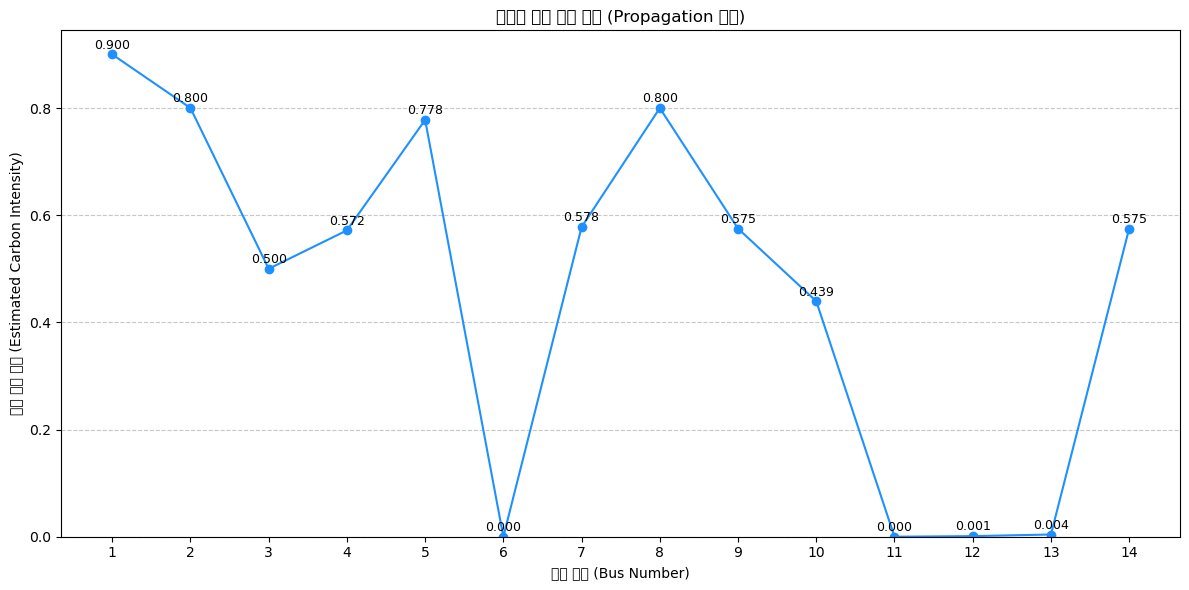

In [83]:
CARBON_INTENSITIES = {
    1: 0.9, 2: 0.8, 3: 0.5, 6: 0.0, 8: 0.8,
}

            # --- 모선별 탄소 강도 계산 (전파 방식) ---
            # ... (calculate_bus_ci_propagation 호출 및 딕셔너리 생성) ...
bus_specific_ci_prop = calculate_bus_ci_propagation(final_net, CARBON_INTENSITIES, bus_data)

print("\n=== 모선별 탄소 강도 (Propagation 방식 추정치) ===")
# ... (기존 텍스트 출력 코드) ...
bus_ids_for_plot = []
ci_values_for_plot = []
if bus_specific_ci_prop:
    all_bus_ids = range(1, NUM_BUSES + 1)
    for bus_id in all_bus_ids:
            ci_value = bus_specific_ci_prop.get(bus_id, np.nan)
            # 그래프에는 계산된 유효한 값만 포함
            if not np.isnan(ci_value):
                print(f"  모선 {bus_id}: {ci_value:.4f}")
                bus_ids_for_plot.append(bus_id)
                ci_values_for_plot.append(ci_value)
            else:
                print(f"  모선 {bus_id}: N/A")
                # 꺾은선 그래프에서는 보통 NaN/없는 값은 연결하지 않거나 표시하지 않음
                # 0으로 표시하려면 아래 추가
                # bus_ids_for_plot.append(bus_id)
                # ci_values_for_plot.append(0.0) # NaN 대신 0

else: print("  모선별 탄소 강도 계산 불가.")

# --- 탄소 강도 꺾은선 그래프 생성 ---
if bus_ids_for_plot: # Plot only if there is data
    try:
        import matplotlib.pyplot as plt
        # matplotlib 한글 폰트 설정 (필요시)
        # try:
        #     plt.rcParams['font.family'] = 'AppleGothic' # macOS
        #     plt.rcParams['axes.unicode_minus'] = False # 마이너스 깨짐 방지
        # except:
        #     print("Warning: AppleGothic font not found. Using default font.")
        #     try:
        #          plt.rcParams['font.family'] = 'Malgun Gothic' # Windows
        #          plt.rcParams['axes.unicode_minus'] = False
        #     except:
        #          print("Warning: Malgun Gothic font not found. Using default font.")


        plt.figure(figsize=(12, 6)) # 그래프 크기 조절
        # 꺾은선 그래프 그리기 (마커 추가)
        plt.plot(bus_ids_for_plot, ci_values_for_plot, marker='o', linestyle='-', color='dodgerblue')

        # 각 데이터 포인트에 값(데이터 레이블) 표시
        for i, txt in enumerate(ci_values_for_plot):
            # plt.text(x좌표, y좌표, 표시할텍스트, 옵션...)
            plt.text(bus_ids_for_plot[i], ci_values_for_plot[i] + 0.005, f'{txt:.3f}', # y좌표 살짝 위에 표시
                        ha='center', va='bottom', fontsize=9) # 가운데 정렬, 아래쪽 기준

        # 그래프 제목 및 축 레이블 설정 (한글 포함 가능)
        plt.xlabel("모선 번호 (Bus Number)")
        plt.ylabel("추정 탄소 강도 (Estimated Carbon Intensity)")
        plt.title("모선별 추정 탄소 강도 (Propagation 방식)")
        # x축 눈금을 정수로, 모든 모선 번호 표시
        plt.xticks(range(1, NUM_BUSES + 1))
        plt.grid(axis='y', linestyle='--', alpha=0.7) # y축 그리드 추가
        plt.ylim(bottom=0) # Y축 시작을 0으로 (선택적)

        plt.tight_layout() # 레이아웃 조정
        plt.show() # 그래프 표시

    except ImportError:
        print("\n그래프를 표시하려면 matplotlib 라이브러리가 필요합니다. (pip install matplotlib)")
    except Exception as e:
        print(f"\n그래프 생성 중 오류 발생: {e}")
else:
    print("\n그래프를 생성할 유효한 탄소 강도 데이터가 없습니다.")


# --- 최종 전압 검증 ---
# ... (이하 코드 동일) ...


Visualizing Carbon Intensity on Network Topology...
Using NetworkX spring_layout for node positions.


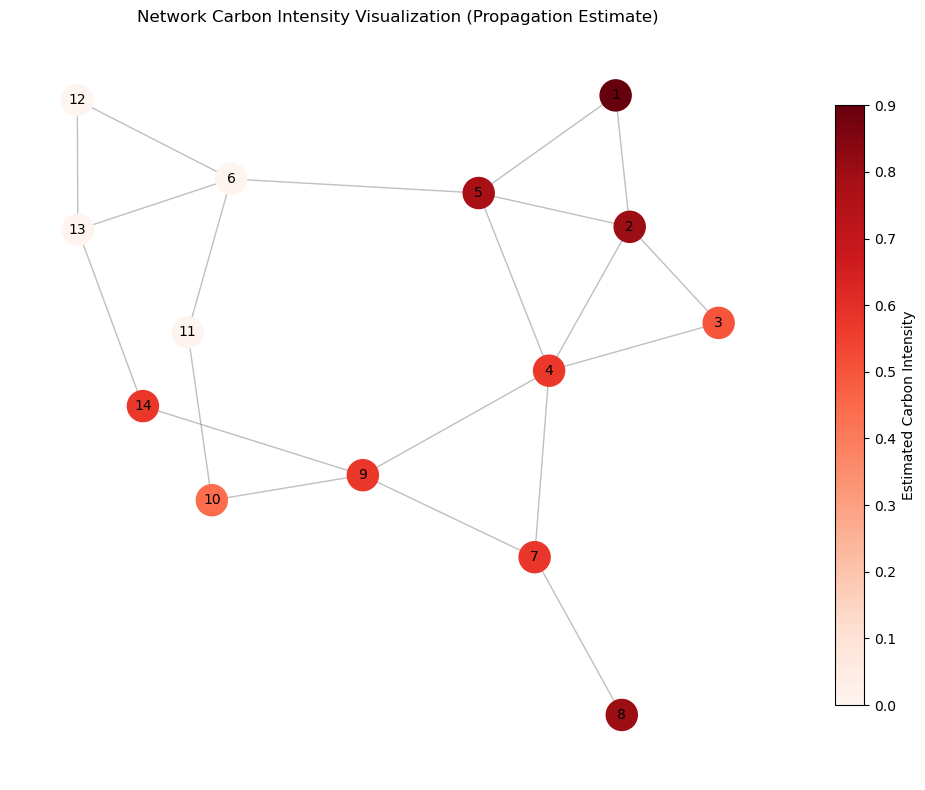

In [86]:
# --- 네트워크 토폴로지 기반 탄소 강도 시각화 (수정) ---
print("\nVisualizing Carbon Intensity on Network Topology...")
if bus_specific_ci_prop and 'final_net' in locals() and callable(get_original_bus_id):
    try:
        import networkx as nx
        import matplotlib.pyplot as plt
        # import matplotlib.cm as cm # cm 대신 plt 사용
        import matplotlib.colors as mcolors

        # --- pp_idx_to_bus_no 매핑 생성 ---
        pp_idx_to_bus_no = {}
        if hasattr(final_net, 'bus'):
            for pp_idx in final_net.bus.index:
                    bus_no = get_original_bus_id(final_net, pp_idx)
                    if bus_no != -1: pp_idx_to_bus_no[pp_idx] = bus_no
        else: raise ValueError("final_net object missing 'bus' attribute.")
        if not pp_idx_to_bus_no: raise ValueError("Could not create pp_idx_to_bus_no mapping.")

        # 1. NetworkX 그래프 생성
        G = nx.Graph()
        all_bus_ids = range(1, NUM_BUSES + 1)
        G.add_nodes_from(all_bus_ids)
        if hasattr(final_net, 'line'):
            for idx, line_info in final_net.line.iterrows():
                    from_pp_idx = line_info.from_bus; to_pp_idx = line_info.to_bus
                    from_bus_id = pp_idx_to_bus_no.get(from_pp_idx); to_bus_id = pp_idx_to_bus_no.get(to_pp_idx)
                    if from_bus_id and to_bus_id: G.add_edge(from_bus_id, to_bus_id)
        else: print("Warning: final_net object missing 'line' attribute.")

        # 2. 노드 위치 결정
        pos = None
        if pos is None:
                print("Using NetworkX spring_layout for node positions.")
                pos = nx.spring_layout(G, seed=42)

        # 3. 노드 색상 결정
        node_colors = []
        valid_ci_values = [v for v in bus_specific_ci_prop.values() if not np.isnan(v)]
        min_ci, max_ci = 0, 1 # Defaults
        norm = None # Initialize norm
        cmap = None # Initialize cmap
        if valid_ci_values:
            min_ci = min(valid_ci_values); max_ci = max(valid_ci_values)
            norm_range = max_ci - min_ci if max_ci > min_ci else 1
            norm = mcolors.Normalize(vmin=min_ci, vmax=max_ci)
            # --- 수정: plt.get_cmap 사용 ---
            cmap = plt.get_cmap('Reds')

            for node in G.nodes():
                ci = bus_specific_ci_prop.get(node, np.nan)
                if np.isnan(ci): node_colors.append('lightgrey')
                else: node_colors.append(cmap(norm(ci)))
        else: node_colors = ['lightgrey'] * len(G.nodes())

        # 4. 네트워크 그리기
        plt.figure(figsize=(10, 8))
        # --- 수정: 현재 Axes 가져오기 ---
        ax = plt.gca() # Get current axes

        nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray', ax=ax)
        # --- 수정: cmap, vmin, vmax 제거 ---
        nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500, ax=ax)
        nx.draw_networkx_labels(G, pos, font_size=10, ax=ax)

        plt.title("Network Carbon Intensity Visualization (Propagation Estimate)")
        # Remove axis labels and ticks for clarity
        # plt.xlabel("X Coordinate (Layout)"); plt.ylabel("Y Coordinate (Layout)")
        ax.set_xticks([]) # Hide x-axis ticks
        ax.set_yticks([]) # Hide y-axis ticks
        ax.spines['top'].set_visible(False) # Hide frame borders
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)


        # Add a colorbar
        if valid_ci_values and cmap is not None and norm is not None:
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            # --- 수정: ax 인자 전달 ---
            cbar = plt.colorbar(sm, shrink=0.8, ax=ax)
            cbar.set_label('Estimated Carbon Intensity')

        plt.tight_layout()
        plt.show()

    except ImportError: print("\n네트워크 시각화를 위해서는 networkx 및 matplotlib 필요.")
    except Exception as e: print(f"\n네트워크 시각화 중 오류 발생: {e}"); traceback.print_exc()
else: print("\n네트워크 시각화를 위한 데이터 부족.")

# --- 최종 전압 검증 ---
# ... (이하 코드 동일) ...

In [ ]:
import pandapower as pp
import numpy as np

# === 기본 단위 정의 ===
S_base = 100      # MVA
V_base_kv = 22.9  # kV
Z_base = V_base_kv**2 / S_base

# === 시스템 데이터 ===
bus_data = np.array([
    [1,  1,    0.0,       0.0,       1.05, 0.0],    # Slack bus
    [2,  2,   21.7/100,   0.0,       1.05,  None],   # PV bus (Gen)
    [3,  2,   94.2/100,   0.0,       1.05,  None],   # PV bus (Gen)
    [4,  3,    7.8/100,   3.9/100,   None,   None],   # PQ bus (Load)
    [5,  3,    7.6/100,   0.6/100,   None,   None],
    [6,  2,   11.2/100,   0.0,       1.05,  None],   # PV bus (Gen)
    [7,  3,    1.0/100,   0.0,       None,   None],
    [8,  2,    5.0/100,   0.0,       1.05,  None],   # PV bus (Gen)
    [9,  3,   29.5/100,   3.6/100,   None,   None],
    [10, 3,    9/100,     1.5/100,   None,   None],
    [11, 3,    3.5/100,   0.1/100,   None,   None],
    [12, 3,    6.1/100,   0.6/100,   None,   None],
    [13, 3,    3.7/100,   2.8/100,   None,   None],
    [14, 3,    2.0/100,   1.0/100,   None,   None],
], dtype=object)

branch_data = np.array([
    [1, 2, 0.01938, 0.05917, 0.0528],
    [1, 5, 0.05403, 0.22304, 0.0492],
    [2, 3, 0.04699, 0.19797, 0.0438],
    [2, 4, 0.05811, 0.17632, 0.0340],
    [2, 5, 0.05695, 0.17388, 0.0346],
    [3, 4, 0.06701, 0.17103, 0.0128],
    [4, 5, 0.01335, 0.04211, 0.0   ],
    [4, 7, 0.0,     0.20912, 0.0   ],
    [4, 9, 0.0,     0.55618, 0.0   ],
    [5, 6, 0.0,     0.25202, 0.0   ],
    [6,11, 0.09498, 0.19890, 0.0   ],
    [6,12, 0.12291, 0.25581, 0.0   ],
    [6,13, 0.06615, 0.13027, 0.0   ],
    [7, 8, 0.0,     0.17615, 0.0   ],
    [7, 9, 0.0,     0.11001, 0.0   ],
    [9,10, 0.03181, 0.08450, 0.0   ],
    [9,14, 0.12711, 0.27038, 0.0   ],
    [10,11,0.08205, 0.19207, 0.0   ],
    [12,13,0.22092, 0.19988, 0.0   ],
    [13,14,0.17093, 0.34802, 0.0   ],
], dtype=object)

# === 빈 네트워크 생성 ===
net = pp.create_empty_network()

# === 버스 생성 ===
bus_lookup = {}
for row in bus_data:
    bus_no = int(row[0])
    bus_lookup[bus_no] = pp.create_bus(net, vn_kv=V_base_kv, name=f"Bus {bus_no}")

# === 발전기 및 부하 생성 ===
for row in bus_data:
    bus_no, btype, Ppu, Qpu, Vsp, _ = row
    bus_no = int(bus_no)
    if btype == 1:
        # Slack (External Grid)
        pp.create_ext_grid(net, bus=bus_lookup[bus_no], vm_pu=Vsp, name=f"Slack {bus_no}")
    elif btype == 2:
        # PV bus (Generator)
        pp.create_gen(net, bus=bus_lookup[bus_no], p_mw=Ppu * S_base, vm_pu=Vsp, name=f"Gen {bus_no}")
    elif btype == 3:
        # PQ bus (Load)
        pp.create_load(net, bus=bus_lookup[bus_no], p_mw=Ppu * S_base, q_mvar=Qpu * S_base, name=f"Load {bus_no}")

# === 선로 생성 ===
for row in branch_data:
    fbus, tbus, r_pu, x_pu, _ = row
    r_ohm = r_pu * Z_base
    x_ohm = x_pu * Z_base
    pp.create_line_from_parameters(
        net,
        from_bus=bus_lookup[int(fbus)],
        to_bus=bus_lookup[int(tbus)],
        length_km=1.0,
        r_ohm_per_km=r_ohm,
        x_ohm_per_km=x_ohm,
        c_nf_per_km=0.0,
        max_i_ka=1.0,
        name=f"Line {int(fbus)}-{int(tbus)}"
    )

# === 전력 흐름 계산 실행 ===
pp.runpp(net)

# === 결과 출력 ===
print("버스 전압 (pu, 각도):")
print(net.res_bus[["vm_pu", "va_degree"]])
print("\n지선 전력 흐름 (MW):")
print(net.res_line[["p_from_mw", "p_to_mw"]])
